Import libraries

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import glob
import zipfile
from zipfile import BadZipFile
import datetime
import pandas as pd
import hyp3_sdk as sdk
from hyp3_sdk import asf_search
from tqdm.notebook import trange, tqdm
from hyp3lib import cutGeotiffs
import geopandas as gpd
# from tqdm.auto import tqdm

In [66]:
# gdf = gpd.read_file('desc-lower-2021-10-21.geojson')
gdf = gpd.read_file('desc-lower-2021-10-21.geojson')
min_date = pd.to_datetime('20140201T000000')
max_date = pd.to_datetime('20210630T000000')

In [67]:
gdf = gdf.loc[:,['fileName','startTime','geometry']]
gdf = gdf.to_crs(epsg=32760)
gdf['startTime'] = pd.to_datetime(gdf.startTime)
gdf = gdf.sort_values('startTime').reset_index(drop=True)
# gdf = gdf.loc[gdf.startTime <= max_date]

In [68]:
template = gdf.loc[gdf.startTime==gdf.startTime.max()]
union = gpd.overlay(gdf, template, how='intersection')
gdf['intersect'] = union.area / template.area.item()

n ifgs: 133


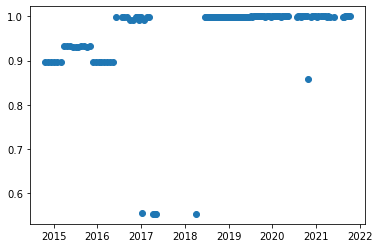

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(gdf.startTime,gdf.intersect)
print(f'n ifgs: {len(gdf)}')

In [73]:
min_date = pd.to_datetime('20180101T000000')
slcs = gdf[(gdf.intersect>0.95) & (gdf.startTime>=min_date)].copy().reset_index(drop=True)
print(f'Removed {gdf.shape[0] - slcs.shape[0]} of {gdf.shape[0]} SLCs')

Removed 46 of 133 SLCs


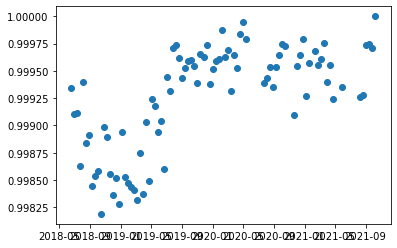

In [74]:
plt.scatter(slcs.startTime,slcs.intersect)

In [77]:
reference

'S1A_IW_SLC__1SDV_20211009T173042_20211009T173109_040045_04BD99_15D4'

In [83]:
pairs = {}
names = slcs.fileName.str[:-4]
length = names.shape[0]

In [84]:
for i,reference in enumerate(names):
    secondary = []
    for j in [1,2,3]:
        index = i+j
        if index < length:
            secondary.append(names[index])
    if secondary != []:
        pairs[reference] = secondary

print(f'This includes {(len(pairs)-1)*3} interferograms')

This includes 255 interferograms


Enter Hyp3 credentials

In [87]:
hyp3 = sdk.HyP3(prompt=True)
my_info = hyp3.my_info()
print(f"Remaining Quota: {my_info['quota']['remaining']}")

NASA Earthdata Login username:  forrestfwilliams
NASA Earthdata Login password:  ····················


Remaining Quota: 1000


Create download list

In [ ]:
# # Project name
# # project_name = 'ifg_a_p81_f1048_20x4'
# project_name = 'p81f1048_10x2_2'

# # Set date bounds
# start_date = datetime.datetime(2017, 12, 31)
# end_date = datetime.datetime(2021, 12, 31)

# # Read in 
# df = pd.read_csv('slcs_asc_path81_frame1048.csv',usecols=['Granule Name', 'Acquisition Date'])

# # Convert and limit by date
# df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S')
# df = df.loc[(df['Acquisition Date']>=start_date) & (df['Acquisition Date']<=end_date)]
# df = df.sort_values('Acquisition Date')

# granules = list(df['Granule Name'])
# print(f'Will create interferograms for {len(granules)} SLCs')

Request Ifg generation

In [88]:
project_name = 'desc_lower'

insar_jobs = sdk.Batch()
first = True

options = {'name':project_name,'looks':'10x2', 'include_wrapped_phase':False, 'apply_water_mask':True}
initial_options = dict(options)
initial_options.update({'include_inc_map':True,'include_dem':True,'include_look_vectors':True})

In [89]:
for reference in tqdm(pairs):
    for secondary in pairs[reference]:
        if first:
            insar_jobs += hyp3.submit_insar_job(reference, secondary, **initial_options)
            first = False
        else:
            insar_jobs += hyp3.submit_insar_job(reference, secondary, **options)

  0%|          | 0/86 [00:00<?, ?it/s]

Check progress and download

In [91]:
batch = hyp3.find_jobs(name=project_name)

if batch.complete():
    #filter to only succeeded jobs
    succeeded_jobs = batch.filter_jobs(succeeded=True, running=False, failed=False)
    
    complete = 0
    #download files if not downloaded already
    for job in succeeded_jobs.jobs:
        filename = job.to_dict()['files'][0]['filename']
        location = os.path.join(project_name,filename)
        if not os.path.exists(location):
            job.download_files(location=project_name,create=True)
        else:
            complete += 1

    print(f'{complete} files already downloaded!')

else:
    #to get updated information
    batch = hyp3.refresh(batch)
    #or to wait until completion and get updated information (which will take a fair bit)
    batch = hyp3.watch(batch)

S1AA_20210927T173042_20211009T173042_VVR012_INT40_G_weF_66DB.zip:   0%|          | 0/304486074 [00:00<?, ?it/s…

S1AA_20210915T173041_20211009T173042_VVR024_INT40_G_weF_EA1F.zip:   0%|          | 0/301280779 [00:00<?, ?it/s…

S1AA_20210915T173041_20210927T173042_VVP012_INT40_G_weF_240A.zip:   0%|          | 0/301779827 [00:00<?, ?it/s…

S1AA_20210903T173041_20211009T173042_VVR036_INT40_G_weF_314D.zip:   0%|          | 0/301626340 [00:00<?, ?it/s…

S1AA_20210903T173041_20210915T173041_VVP012_INT40_G_weF_FCAC.zip:   0%|          | 0/301046460 [00:00<?, ?it/s…

S1AA_20210903T173041_20210927T173042_VVP024_INT40_G_weF_BC8D.zip:   0%|          | 0/301082866 [00:00<?, ?it/s…

S1AA_20210822T173040_20210915T173041_VVP024_INT40_G_weF_56C0.zip:   0%|          | 0/302909401 [00:00<?, ?it/s…

S1AA_20210822T173040_20210927T173042_VVP036_INT40_G_weF_06B3.zip:   0%|          | 0/301807403 [00:00<?, ?it/s…

S1AA_20210810T173040_20210903T173041_VVP024_INT40_G_weF_3684.zip:   0%|          | 0/302034269 [00:00<?, ?it/s…

S1AA_20210810T173040_20210915T173041_VVP036_INT40_G_weF_0B85.zip:   0%|          | 0/304345974 [00:00<?, ?it/s…

S1AA_20210822T173040_20210903T173041_VVP012_INT40_G_weF_F6F7.zip:   0%|          | 0/300874522 [00:00<?, ?it/s…

S1AA_20210530T173035_20210903T173041_VVP096_INT40_G_weF_859B.zip:   0%|          | 0/304065935 [00:00<?, ?it/s…

S1AA_20210810T173040_20210822T173040_VVP012_INT40_G_weF_E700.zip:   0%|          | 0/300986897 [00:00<?, ?it/s…

S1AA_20210530T173035_20210822T173040_VVP084_INT40_G_weF_9643.zip:   0%|          | 0/301911454 [00:00<?, ?it/s…

S1AA_20210530T173035_20210810T173040_VVP072_INT40_G_weF_A0B5.zip:   0%|          | 0/304531819 [00:00<?, ?it/s…

S1AA_20210424T173034_20210822T173040_VVP120_INT40_G_weF_1F03.zip:   0%|          | 0/302358621 [00:00<?, ?it/s…

S1AA_20210424T173034_20210530T173035_VVP036_INT40_G_weF_2AEC.zip:   0%|          | 0/301500876 [00:00<?, ?it/s…

S1AA_20210424T173034_20210810T173040_VVP108_INT40_G_weF_28C7.zip:   0%|          | 0/303970930 [00:00<?, ?it/s…

S1AA_20210412T173033_20210530T173035_VVP048_INT40_G_weF_0BE2.zip:   0%|          | 0/303426969 [00:00<?, ?it/s…

S1AA_20210412T173033_20210810T173040_VVP120_INT40_G_weF_7DBE.zip:   0%|          | 0/302531565 [00:00<?, ?it/s…

S1AA_20210331T173033_20210530T173035_VVP060_INT40_G_weF_2200.zip:   0%|          | 0/303412811 [00:00<?, ?it/s…

S1AA_20210412T173033_20210424T173034_VVP012_INT40_G_weF_9534.zip:   0%|          | 0/303856791 [00:00<?, ?it/s…

S1AA_20210331T173033_20210412T173033_VVP012_INT40_G_weF_FDC7.zip:   0%|          | 0/303438299 [00:00<?, ?it/s…

S1AA_20210331T173033_20210424T173034_VVP024_INT40_G_weF_53EC.zip:   0%|          | 0/303205664 [00:00<?, ?it/s…

S1AA_20210319T173032_20210412T173033_VVP024_INT40_G_weF_E441.zip:   0%|          | 0/302941296 [00:00<?, ?it/s…

S1AA_20210319T173032_20210424T173034_VVP036_INT40_G_weF_6F4A.zip:   0%|          | 0/301605691 [00:00<?, ?it/s…

S1AA_20210307T173032_20210412T173033_VVP036_INT40_G_weF_7FF2.zip:   0%|          | 0/301885604 [00:00<?, ?it/s…

S1AA_20210307T173032_20210331T173033_VVP024_INT40_G_weF_61D6.zip:   0%|          | 0/304057768 [00:00<?, ?it/s…

S1AA_20210319T173032_20210331T173033_VVP012_INT40_G_weF_CBDE.zip:   0%|          | 0/304315773 [00:00<?, ?it/s…

S1AA_20210307T173032_20210319T173032_VVP012_INT40_G_weF_396C.zip:   0%|          | 0/302488961 [00:00<?, ?it/s…

S1AA_20210223T173032_20210331T173033_VVP036_INT40_G_weF_2352.zip:   0%|          | 0/303974241 [00:00<?, ?it/s…

S1AA_20210223T173032_20210319T173032_VVP024_INT40_G_weF_18BB.zip:   0%|          | 0/303481253 [00:00<?, ?it/s…

S1AA_20210223T173032_20210307T173032_VVP012_INT40_G_weF_FD39.zip:   0%|          | 0/302204558 [00:00<?, ?it/s…

S1AA_20210211T173033_20210307T173032_VVP024_INT40_G_weF_B11B.zip:   0%|          | 0/301992870 [00:00<?, ?it/s…

S1AA_20210211T173033_20210319T173032_VVP036_INT40_G_weF_5C96.zip:   0%|          | 0/303907933 [00:00<?, ?it/s…

S1AA_20210211T173033_20210223T173032_VVP012_INT40_G_weF_AAEB.zip:   0%|          | 0/302724971 [00:00<?, ?it/s…

S1AA_20210118T173033_20210307T173032_VVP048_INT40_G_weF_F3F1.zip:   0%|          | 0/303865458 [00:00<?, ?it/s…

S1AA_20210118T173033_20210211T173033_VVP024_INT40_G_weF_E0CE.zip:   0%|          | 0/301025801 [00:00<?, ?it/s…

S1AA_20210118T173033_20210223T173032_VVP036_INT40_G_weF_61DF.zip:   0%|          | 0/301648925 [00:00<?, ?it/s…

S1AA_20210106T173034_20210223T173032_VVP048_INT40_G_weF_6AA9.zip:   0%|          | 0/300398292 [00:00<?, ?it/s…

S1AA_20210106T173034_20210211T173033_VVP036_INT40_G_weF_8DEA.zip:   0%|          | 0/300993337 [00:00<?, ?it/s…

S1AA_20210106T173034_20210118T173033_VVP012_INT40_G_weF_454D.zip:   0%|          | 0/303054201 [00:00<?, ?it/s…

S1AA_20201225T173034_20210118T173033_VVP024_INT40_G_weF_C54C.zip:   0%|          | 0/301041915 [00:00<?, ?it/s…

S1AA_20201225T173034_20210211T173033_VVP048_INT40_G_weF_9269.zip:   0%|          | 0/302714183 [00:00<?, ?it/s…

S1AA_20201225T173034_20210106T173034_VVP012_INT40_G_weF_D00D.zip:   0%|          | 0/301374474 [00:00<?, ?it/s…

S1AA_20201213T173035_20210118T173033_VVP036_INT40_G_weF_7860.zip:   0%|          | 0/300856548 [00:00<?, ?it/s…

S1AA_20201213T173035_20201225T173034_VVP012_INT40_G_weF_F2E5.zip:   0%|          | 0/304185352 [00:00<?, ?it/s…

S1AA_20201201T173035_20210106T173034_VVP036_INT40_G_weF_0789.zip:   0%|          | 0/299581819 [00:00<?, ?it/s…

S1AA_20201213T173035_20210106T173034_VVP024_INT40_G_weF_FFE4.zip:   0%|          | 0/301149685 [00:00<?, ?it/s…

S1AA_20201201T173035_20201225T173034_VVP024_INT40_G_weF_340A.zip:   0%|          | 0/304454225 [00:00<?, ?it/s…

S1AA_20201201T173035_20201213T173035_VVP012_INT40_G_weF_168F.zip:   0%|          | 0/303237901 [00:00<?, ?it/s…

S1AA_20201119T173036_20201225T173034_VVP036_INT40_G_weF_CAE2.zip:   0%|          | 0/302348024 [00:00<?, ?it/s…

S1AA_20201119T173036_20201213T173035_VVP024_INT40_G_weF_A0D1.zip:   0%|          | 0/303870122 [00:00<?, ?it/s…

S1AA_20201119T173036_20201201T173035_VVP012_INT40_G_weF_081F.zip:   0%|          | 0/302968330 [00:00<?, ?it/s…

S1AA_20201014T173036_20201201T173035_VVP048_INT40_G_weF_41B2.zip:   0%|          | 0/303684790 [00:00<?, ?it/s…

S1AA_20201014T173036_20201213T173035_VVP060_INT40_G_weF_1B7E.zip:   0%|          | 0/303536547 [00:00<?, ?it/s…

S1AA_20201002T173036_20201201T173035_VVP060_INT40_G_weF_62CD.zip:   0%|          | 0/299617353 [00:00<?, ?it/s…

S1AA_20201014T173036_20201119T173036_VVP036_INT40_G_weF_C88C.zip:   0%|          | 0/302884722 [00:00<?, ?it/s…

S1AA_20201002T173036_20201014T173036_VVP012_INT40_G_weF_1B85.zip:   0%|          | 0/299802700 [00:00<?, ?it/s…

S1AA_20201002T173036_20201119T173036_VVP048_INT40_G_weF_E368.zip:   0%|          | 0/300876461 [00:00<?, ?it/s…

S1AA_20200920T173036_20201014T173036_VVP024_INT40_G_weF_AB8F.zip:   0%|          | 0/301226971 [00:00<?, ?it/s…

S1AA_20200920T173036_20201119T173036_VVP060_INT40_G_weF_79DA.zip:   0%|          | 0/304237336 [00:00<?, ?it/s…

S1AA_20200920T173036_20201002T173036_VVP012_INT40_G_weF_EE28.zip:   0%|          | 0/300073908 [00:00<?, ?it/s…

S1AA_20200908T173035_20201014T173036_VVP036_INT40_G_weF_1E6A.zip:   0%|          | 0/300385845 [00:00<?, ?it/s…

S1AA_20200908T173035_20201002T173036_VVP024_INT40_G_weF_E9AA.zip:   0%|          | 0/300561510 [00:00<?, ?it/s…

S1AA_20200908T173035_20200920T173036_VVP012_INT40_G_weF_867A.zip:   0%|          | 0/298318002 [00:00<?, ?it/s…

S1AA_20200827T173035_20200908T173035_VVP012_INT40_G_weF_0ADA.zip:   0%|          | 0/301641549 [00:00<?, ?it/s…

S1AA_20200827T173035_20201002T173036_VVP036_INT40_G_weF_8212.zip:   0%|          | 0/301986794 [00:00<?, ?it/s…

S1AA_20200827T173035_20200920T173036_VVP024_INT40_G_weF_B12C.zip:   0%|          | 0/304570639 [00:00<?, ?it/s…

S1AA_20200815T173034_20200908T173035_VVP024_INT40_G_weF_7F71.zip:   0%|          | 0/298974795 [00:00<?, ?it/s…

S1AA_20200815T173034_20200920T173036_VVP036_INT40_G_weF_58A6.zip:   0%|          | 0/300373776 [00:00<?, ?it/s…

S1AA_20200815T173034_20200827T173035_VVP012_INT40_G_weF_BBFB.zip:   0%|          | 0/301303835 [00:00<?, ?it/s…

S1AA_20200803T173034_20200908T173035_VVP036_INT40_G_weF_1D03.zip:   0%|          | 0/299894777 [00:00<?, ?it/s…

S1AA_20200803T173034_20200827T173035_VVP024_INT40_G_weF_BF4F.zip:   0%|          | 0/301845321 [00:00<?, ?it/s…

S1AA_20200803T173034_20200815T173034_VVP012_INT40_G_weF_6500.zip:   0%|          | 0/300086988 [00:00<?, ?it/s…

S1AA_20200722T173033_20200827T173035_VVP036_INT40_G_weF_DF83.zip:   0%|          | 0/301820897 [00:00<?, ?it/s…

S1AA_20200722T173033_20200815T173034_VVP024_INT40_G_weF_C4DF.zip:   0%|          | 0/299869017 [00:00<?, ?it/s…

S1AA_20200511T173029_20200815T173034_VVP096_INT40_G_weF_F75D.zip:   0%|          | 0/301965677 [00:00<?, ?it/s…

S1AA_20200511T173029_20200803T173034_VVP084_INT40_G_weF_4ED2.zip:   0%|          | 0/303562523 [00:00<?, ?it/s…

S1AA_20200722T173033_20200803T173034_VVP012_INT40_G_weF_3999.zip:   0%|          | 0/299741242 [00:00<?, ?it/s…

S1AA_20200429T173028_20200803T173034_VVP096_INT40_G_weF_B61A.zip:   0%|          | 0/301429202 [00:00<?, ?it/s…

S1AA_20200511T173029_20200722T173033_VVP072_INT40_G_weF_754D.zip:   0%|          | 0/304052137 [00:00<?, ?it/s…

S1AA_20200429T173028_20200722T173033_VVP084_INT40_G_weF_7B50.zip:   0%|          | 0/301006412 [00:00<?, ?it/s…

S1AA_20200429T173028_20200511T173029_VVP012_INT40_G_weF_65BA.zip:   0%|          | 0/299302145 [00:00<?, ?it/s…

S1AA_20200417T173027_20200511T173029_VVP024_INT40_G_weF_164A.zip:   0%|          | 0/302999371 [00:00<?, ?it/s…

S1AA_20200417T173027_20200722T173033_VVP096_INT40_G_weF_D204.zip:   0%|          | 0/303900589 [00:00<?, ?it/s…

S1AA_20200417T173027_20200429T173028_VVP012_INT40_G_weF_7461.zip:   0%|          | 0/302857348 [00:00<?, ?it/s…

S1AA_20200405T173027_20200511T173029_VVP036_INT40_G_weF_9437.zip:   0%|          | 0/305276376 [00:00<?, ?it/s…

S1AA_20200405T173027_20200429T173028_VVP024_INT40_G_weF_773B.zip:   0%|          | 0/301562758 [00:00<?, ?it/s…

S1AA_20200405T173027_20200417T173027_VVP012_INT40_G_weF_9D6B.zip:   0%|          | 0/303436762 [00:00<?, ?it/s…

S1AA_20200324T173027_20200429T173028_VVP036_INT40_G_weF_C89B.zip:   0%|          | 0/302531019 [00:00<?, ?it/s…

S1AA_20200324T173027_20200417T173027_VVP024_INT40_G_weF_D168.zip:   0%|          | 0/303137656 [00:00<?, ?it/s…

S1AA_20200312T173027_20200417T173027_VVP036_INT40_G_weF_B7FD.zip:   0%|          | 0/301239482 [00:00<?, ?it/s…

S1AA_20200324T173027_20200405T173027_VVP012_INT40_G_weF_D1A3.zip:   0%|          | 0/304123101 [00:00<?, ?it/s…

S1AA_20200312T173027_20200405T173027_VVP024_INT40_G_weF_1403.zip:   0%|          | 0/301304703 [00:00<?, ?it/s…

S1AA_20200312T173027_20200324T173027_VVP012_INT40_G_weF_28C2.zip:   0%|          | 0/299009537 [00:00<?, ?it/s…

S1AA_20200229T173026_20200324T173027_VVP024_INT40_G_weF_217F.zip:   0%|          | 0/303226346 [00:00<?, ?it/s…

S1AA_20200229T173026_20200312T173027_VVP012_INT40_G_weF_3CC1.zip:   0%|          | 0/300506105 [00:00<?, ?it/s…

S1AA_20200229T173026_20200405T173027_VVP036_INT40_G_weF_F811.zip:   0%|          | 0/303146967 [00:00<?, ?it/s…

S1AA_20200217T173027_20200324T173027_VVP036_INT40_G_weF_62F5.zip:   0%|          | 0/302998040 [00:00<?, ?it/s…

S1AA_20200217T173027_20200312T173027_VVP024_INT40_G_weF_DF4B.zip:   0%|          | 0/300109809 [00:00<?, ?it/s…

S1AA_20200217T173027_20200229T173026_VVP012_INT40_G_weF_C5B9.zip:   0%|          | 0/301411116 [00:00<?, ?it/s…

S1AA_20200205T173027_20200312T173027_VVP036_INT40_G_weF_535C.zip:   0%|          | 0/302123404 [00:00<?, ?it/s…

S1AA_20200205T173027_20200217T173027_VVP012_INT40_G_weF_4CE4.zip:   0%|          | 0/302248241 [00:00<?, ?it/s…

S1AA_20200205T173027_20200229T173026_VVP024_INT40_G_weF_5370.zip:   0%|          | 0/301465846 [00:00<?, ?it/s…

S1AA_20200124T173027_20200217T173027_VVP024_INT40_G_weF_3FB9.zip:   0%|          | 0/302033729 [00:00<?, ?it/s…

S1AA_20200124T173027_20200229T173026_VVP036_INT40_G_weF_75FD.zip:   0%|          | 0/303592222 [00:00<?, ?it/s…

S1AA_20200112T173028_20200217T173027_VVP036_INT40_G_weF_281C.zip:   0%|          | 0/303213975 [00:00<?, ?it/s…

S1AA_20200124T173027_20200205T173027_VVP012_INT40_G_weF_174D.zip:   0%|          | 0/301760474 [00:00<?, ?it/s…

S1AA_20200112T173028_20200205T173027_VVP024_INT40_G_weF_22AF.zip:   0%|          | 0/302645788 [00:00<?, ?it/s…

S1AA_20200112T173028_20200124T173027_VVP012_INT40_G_weF_222E.zip:   0%|          | 0/302375193 [00:00<?, ?it/s…

S1AA_20191231T173028_20200124T173027_VVP024_INT40_G_weF_218C.zip:   0%|          | 0/303850040 [00:00<?, ?it/s…

S1AA_20191231T173028_20200205T173027_VVP036_INT40_G_weF_4CF1.zip:   0%|          | 0/304186334 [00:00<?, ?it/s…

S1AA_20191219T173029_20200124T173027_VVP036_INT40_G_weF_77B1.zip:   0%|          | 0/300487596 [00:00<?, ?it/s…

S1AA_20191231T173028_20200112T173028_VVP012_INT40_G_weF_3ACD.zip:   0%|          | 0/302438625 [00:00<?, ?it/s…

S1AA_20191219T173029_20200112T173028_VVP024_INT40_G_weF_AE4E.zip:   0%|          | 0/301958225 [00:00<?, ?it/s…

S1AA_20191207T173029_20200112T173028_VVP036_INT40_G_weF_1ED6.zip:   0%|          | 0/302208102 [00:00<?, ?it/s…

S1AA_20191219T173029_20191231T173028_VVP012_INT40_G_weF_F8B6.zip:   0%|          | 0/299309059 [00:00<?, ?it/s…

S1AA_20191207T173029_20191219T173029_VVP012_INT40_G_weF_AF25.zip:   0%|          | 0/300741579 [00:00<?, ?it/s…

S1AA_20191207T173029_20191231T173028_VVP024_INT40_G_weF_8531.zip:   0%|          | 0/301232817 [00:00<?, ?it/s…

S1AA_20191125T173029_20191231T173028_VVP036_INT40_G_weF_6252.zip:   0%|          | 0/303275524 [00:00<?, ?it/s…

S1AA_20191125T173029_20191219T173029_VVP024_INT40_G_weF_C7E0.zip:   0%|          | 0/299865299 [00:00<?, ?it/s…

S1AA_20191113T173030_20191219T173029_VVP036_INT40_G_weF_9706.zip:   0%|          | 0/299149482 [00:00<?, ?it/s…

S1AA_20191125T173029_20191207T173029_VVP012_INT40_G_weF_0C84.zip:   0%|          | 0/301925292 [00:00<?, ?it/s…

S1AA_20191113T173030_20191125T173029_VVP012_INT40_G_weF_E6C4.zip:   0%|          | 0/301421135 [00:00<?, ?it/s…

S1AA_20191113T173030_20191207T173029_VVP024_INT40_G_weF_5BCA.zip:   0%|          | 0/301227725 [00:00<?, ?it/s…

S1AA_20191101T173030_20191207T173029_VVP036_INT40_G_weF_8303.zip:   0%|          | 0/301543762 [00:00<?, ?it/s…

S1AA_20191101T173030_20191125T173029_VVP024_INT40_G_weF_C39C.zip:   0%|          | 0/303230154 [00:00<?, ?it/s…

S1AA_20191101T173030_20191113T173030_VVP012_INT40_G_weF_80D6.zip:   0%|          | 0/301449410 [00:00<?, ?it/s…

S1AA_20191020T173030_20191125T173029_VVP036_INT40_G_weF_B0C3.zip:   0%|          | 0/300464404 [00:00<?, ?it/s…

S1AA_20191020T173030_20191113T173030_VVP024_INT40_G_weF_806F.zip:   0%|          | 0/303215174 [00:00<?, ?it/s…

S1AA_20191020T173030_20191101T173030_VVP012_INT40_G_weF_AEBC.zip:   0%|          | 0/299515561 [00:00<?, ?it/s…

S1AA_20191008T173030_20191113T173030_VVP036_INT40_G_weF_C6DF.zip:   0%|          | 0/302423790 [00:00<?, ?it/s…

S1AA_20191008T173030_20191101T173030_VVP024_INT40_G_weF_9F1F.zip:   0%|          | 0/301408652 [00:00<?, ?it/s…

S1AA_20191008T173030_20191020T173030_VVP012_INT40_G_weF_2EBB.zip:   0%|          | 0/303389873 [00:00<?, ?it/s…

S1AA_20190926T173030_20191101T173030_VVP036_INT40_G_weF_C2F6.zip:   0%|          | 0/302991732 [00:00<?, ?it/s…

S1AA_20190926T173030_20191020T173030_VVP024_INT40_G_weF_DE6A.zip:   0%|          | 0/300224489 [00:00<?, ?it/s…

S1AA_20190926T173030_20191008T173030_VVP012_INT40_G_weF_8135.zip:   0%|          | 0/299634645 [00:00<?, ?it/s…

S1AA_20190914T173029_20191008T173030_VVP024_INT40_G_weF_A641.zip:   0%|          | 0/302233299 [00:00<?, ?it/s…

S1AA_20190914T173029_20191020T173030_VVP036_INT40_G_weF_5BB1.zip:   0%|          | 0/300107177 [00:00<?, ?it/s…

S1AA_20190914T173029_20190926T173030_VVP012_INT40_G_weF_120D.zip:   0%|          | 0/302681081 [00:00<?, ?it/s…

S1AA_20190902T173029_20191008T173030_VVP036_INT40_G_weF_429A.zip:   0%|          | 0/300948095 [00:00<?, ?it/s…

S1AA_20190902T173029_20190926T173030_VVP024_INT40_G_weF_DE83.zip:   0%|          | 0/300754475 [00:00<?, ?it/s…

S1AA_20190902T173029_20190914T173029_VVP012_INT40_G_weF_0F69.zip:   0%|          | 0/300766898 [00:00<?, ?it/s…

S1AA_20190821T173028_20190926T173030_VVP036_INT40_G_weF_6DB2.zip:   0%|          | 0/303459208 [00:00<?, ?it/s…

S1AA_20190821T173028_20190914T173029_VVP024_INT40_G_weF_4CB3.zip:   0%|          | 0/303672343 [00:00<?, ?it/s…

S1AA_20190821T173028_20190902T173029_VVP012_INT40_G_weF_B61C.zip:   0%|          | 0/303396862 [00:00<?, ?it/s…

S1AA_20190809T173027_20190914T173029_VVP036_INT40_G_weF_C58F.zip:   0%|          | 0/303286967 [00:00<?, ?it/s…

S1AA_20190809T173027_20190902T173029_VVP024_INT40_G_weF_D995.zip:   0%|          | 0/301624428 [00:00<?, ?it/s…

S1AA_20190809T173027_20190821T173028_VVP012_INT40_G_weF_6F28.zip:   0%|          | 0/303327064 [00:00<?, ?it/s…

S1AA_20190728T173027_20190902T173029_VVP036_INT40_G_weF_1D79.zip:   0%|          | 0/303664436 [00:00<?, ?it/s…

S1AA_20190728T173027_20190821T173028_VVP024_INT40_G_weF_383C.zip:   0%|          | 0/304711758 [00:00<?, ?it/s…

S1AA_20190728T173027_20190809T173027_VVP012_INT40_G_weF_D6B2.zip:   0%|          | 0/301582450 [00:00<?, ?it/s…

S1AA_20190716T173026_20190821T173028_VVP036_INT40_G_weF_5BEA.zip:   0%|          | 0/301109226 [00:00<?, ?it/s…

S1AA_20190716T173026_20190809T173027_VVP024_INT40_G_weF_16CF.zip:   0%|          | 0/302678663 [00:00<?, ?it/s…

S1AA_20190716T173026_20190728T173027_VVP012_INT40_G_weF_8B41.zip:   0%|          | 0/303370050 [00:00<?, ?it/s…

S1AA_20190704T173025_20190809T173027_VVP036_INT40_G_weF_7AE2.zip:   0%|          | 0/301286249 [00:00<?, ?it/s…

S1AA_20190704T173025_20190716T173026_VVP012_INT40_G_weF_38AD.zip:   0%|          | 0/302069187 [00:00<?, ?it/s…

S1AA_20190622T173024_20190728T173027_VVP036_INT40_G_weF_276B.zip:   0%|          | 0/302630777 [00:00<?, ?it/s…

S1AA_20190704T173025_20190728T173027_VVP024_INT40_G_weF_2373.zip:   0%|          | 0/301460558 [00:00<?, ?it/s…

S1AA_20190622T173024_20190716T173026_VVP024_INT40_G_weF_0622.zip:   0%|          | 0/302607435 [00:00<?, ?it/s…

S1AA_20190610T173023_20190716T173026_VVP036_INT40_G_weF_9AF0.zip:   0%|          | 0/303258781 [00:00<?, ?it/s…

S1AA_20190622T173024_20190704T173025_VVP012_INT40_G_weF_54B7.zip:   0%|          | 0/301215978 [00:00<?, ?it/s…

S1AA_20190610T173023_20190704T173025_VVP024_INT40_G_weF_CDF4.zip:   0%|          | 0/300559696 [00:00<?, ?it/s…

S1AA_20190610T173023_20190622T173024_VVP012_INT40_G_weF_326A.zip:   0%|          | 0/300429511 [00:00<?, ?it/s…

S1AA_20190529T173023_20190704T173025_VVP036_INT40_G_weF_019D.zip:   0%|          | 0/302138383 [00:00<?, ?it/s…

S1AA_20190529T173023_20190622T173024_VVP024_INT40_G_weF_A411.zip:   0%|          | 0/303609506 [00:00<?, ?it/s…

S1AA_20190529T173023_20190610T173023_VVP012_INT40_G_weF_053F.zip:   0%|          | 0/302956198 [00:00<?, ?it/s…

S1AA_20190517T173022_20190610T173023_VVP024_INT40_G_weF_FFCF.zip:   0%|          | 0/303289586 [00:00<?, ?it/s…

S1AA_20190517T173022_20190622T173024_VVP036_INT40_G_weF_3201.zip:   0%|          | 0/303527528 [00:00<?, ?it/s…

S1AA_20190505T173022_20190610T173023_VVP036_INT40_G_weF_DB83.zip:   0%|          | 0/300771123 [00:00<?, ?it/s…

S1AA_20190517T173022_20190529T173023_VVP012_INT40_G_weF_515B.zip:   0%|          | 0/302321491 [00:00<?, ?it/s…

S1AA_20190505T173022_20190529T173023_VVP024_INT40_G_weF_909D.zip:   0%|          | 0/301910722 [00:00<?, ?it/s…

S1AA_20190505T173022_20190517T173022_VVP012_INT40_G_weF_C755.zip:   0%|          | 0/301864036 [00:00<?, ?it/s…

S1AA_20190423T173021_20190517T173022_VVP024_INT40_G_weF_9D90.zip:   0%|          | 0/303252405 [00:00<?, ?it/s…

S1AA_20190423T173021_20190529T173023_VVP036_INT40_G_weF_2CF5.zip:   0%|          | 0/302481611 [00:00<?, ?it/s…

S1AA_20190411T173021_20190517T173022_VVP036_INT40_G_weF_B0B8.zip:   0%|          | 0/304921668 [00:00<?, ?it/s…

S1AA_20190411T173021_20190505T173022_VVP024_INT40_G_weF_3107.zip:   0%|          | 0/302056930 [00:00<?, ?it/s…

S1AA_20190423T173021_20190505T173022_VVP012_INT40_G_weF_01F5.zip:   0%|          | 0/302259455 [00:00<?, ?it/s…

S1AA_20190330T173021_20190505T173022_VVP036_INT40_G_weF_2BD6.zip:   0%|          | 0/300224742 [00:00<?, ?it/s…

S1AA_20190411T173021_20190423T173021_VVP012_INT40_G_weF_FE4D.zip:   0%|          | 0/303962262 [00:00<?, ?it/s…

S1AA_20190330T173021_20190411T173021_VVP012_INT40_G_weF_15A6.zip:   0%|          | 0/303674979 [00:00<?, ?it/s…

S1AA_20190330T173021_20190423T173021_VVP024_INT40_G_weF_50F9.zip:   0%|          | 0/302050001 [00:00<?, ?it/s…

S1AA_20190318T173020_20190423T173021_VVP036_INT40_G_weF_2639.zip:   0%|          | 0/303269929 [00:00<?, ?it/s…

S1AA_20190318T173020_20190411T173021_VVP024_INT40_G_weF_FC70.zip:   0%|          | 0/301384160 [00:00<?, ?it/s…

S1AA_20190318T173020_20190330T173021_VVP012_INT40_G_weF_A715.zip:   0%|          | 0/299873264 [00:00<?, ?it/s…

S1AA_20190306T173020_20190411T173021_VVP036_INT40_G_weF_E3CA.zip:   0%|          | 0/302581336 [00:00<?, ?it/s…

S1AA_20190306T173020_20190318T173020_VVP012_INT40_G_weF_4771.zip:   0%|          | 0/301654167 [00:00<?, ?it/s…

S1AA_20190306T173020_20190330T173021_VVP024_INT40_G_weF_F0B4.zip:   0%|          | 0/300862094 [00:00<?, ?it/s…

S1AA_20190222T173020_20190318T173020_VVP024_INT40_G_weF_12A9.zip:   0%|          | 0/301901484 [00:00<?, ?it/s…

S1AA_20190222T173020_20190330T173021_VVP036_INT40_G_weF_C9E6.zip:   0%|          | 0/300725415 [00:00<?, ?it/s…

S1AA_20190222T173020_20190306T173020_VVP012_INT40_G_weF_1DED.zip:   0%|          | 0/301184815 [00:00<?, ?it/s…

S1AA_20190210T173020_20190318T173020_VVP036_INT40_G_weF_3277.zip:   0%|          | 0/301059929 [00:00<?, ?it/s…

S1AA_20190210T173020_20190222T173020_VVP012_INT40_G_weF_4FAE.zip:   0%|          | 0/301682070 [00:00<?, ?it/s…

S1AA_20190129T173021_20190306T173020_VVP036_INT40_G_weF_4AC0.zip:   0%|          | 0/302548768 [00:00<?, ?it/s…

S1AA_20190210T173020_20190306T173020_VVP024_INT40_G_weF_3C83.zip:   0%|          | 0/301711747 [00:00<?, ?it/s…

S1AA_20190129T173021_20190210T173020_VVP012_INT40_G_weF_6183.zip:   0%|          | 0/299688520 [00:00<?, ?it/s…

S1AA_20190129T173021_20190222T173020_VVP024_INT40_G_weF_E4CC.zip:   0%|          | 0/301758815 [00:00<?, ?it/s…

S1AA_20190117T173021_20190210T173020_VVP024_INT40_G_weF_CC7C.zip:   0%|          | 0/301160946 [00:00<?, ?it/s…

S1AA_20190117T173021_20190222T173020_VVP036_INT40_G_weF_0546.zip:   0%|          | 0/303179376 [00:00<?, ?it/s…

S1AA_20190105T173021_20190210T173020_VVP036_INT40_G_weF_9407.zip:   0%|          | 0/299549929 [00:00<?, ?it/s…

S1AA_20190117T173021_20190129T173021_VVP012_INT40_G_weF_71BC.zip:   0%|          | 0/302827188 [00:00<?, ?it/s…

S1AA_20190105T173021_20190129T173021_VVP024_INT40_G_weF_C10A.zip:   0%|          | 0/302379218 [00:00<?, ?it/s…

S1AA_20190105T173021_20190117T173021_VVP012_INT40_G_weF_73A5.zip:   0%|          | 0/301998175 [00:00<?, ?it/s…

S1AA_20181224T173022_20190129T173021_VVP036_INT40_G_weF_2D36.zip:   0%|          | 0/301224016 [00:00<?, ?it/s…

S1AA_20181224T173022_20190105T173021_VVP012_INT40_G_weF_5085.zip:   0%|          | 0/301470137 [00:00<?, ?it/s…

S1AA_20181224T173022_20190117T173021_VVP024_INT40_G_weF_5015.zip:   0%|          | 0/300994998 [00:00<?, ?it/s…

S1AA_20181212T173022_20181224T173022_VVP012_INT40_G_weF_4240.zip:   0%|          | 0/301753946 [00:00<?, ?it/s…

S1AA_20181212T173022_20190117T173021_VVP036_INT40_G_weF_DF73.zip:   0%|          | 0/302104484 [00:00<?, ?it/s…

S1AA_20181212T173022_20190105T173021_VVP024_INT40_G_weF_D033.zip:   0%|          | 0/302094139 [00:00<?, ?it/s…

S1AA_20181130T173023_20181224T173022_VVP024_INT40_G_weF_A05A.zip:   0%|          | 0/303607245 [00:00<?, ?it/s…

S1AA_20181130T173023_20190105T173021_VVP036_INT40_G_weF_409B.zip:   0%|          | 0/300738750 [00:00<?, ?it/s…

S1AA_20181130T173023_20181212T173022_VVP012_INT40_G_weF_C387.zip:   0%|          | 0/302595808 [00:00<?, ?it/s…

S1AA_20181118T173023_20181224T173022_VVP036_INT40_G_weF_676D.zip:   0%|          | 0/301115967 [00:00<?, ?it/s…

S1AA_20181118T173023_20181212T173022_VVP024_INT40_G_weF_0464.zip:   0%|          | 0/304396477 [00:00<?, ?it/s…

S1AA_20181118T173023_20181130T173023_VVP012_INT40_G_weF_3A40.zip:   0%|          | 0/303330145 [00:00<?, ?it/s…

S1AA_20181106T173023_20181212T173022_VVP036_INT40_G_weF_5249.zip:   0%|          | 0/304174733 [00:00<?, ?it/s…

S1AA_20181106T173023_20181130T173023_VVP024_INT40_G_weF_2DAE.zip:   0%|          | 0/302949247 [00:00<?, ?it/s…

S1AA_20181106T173023_20181118T173023_VVP012_INT40_G_weF_C691.zip:   0%|          | 0/303793014 [00:00<?, ?it/s…

S1AA_20181025T173024_20181130T173023_VVP036_INT40_G_weF_C7C6.zip:   0%|          | 0/304116232 [00:00<?, ?it/s…

S1AA_20181025T173024_20181118T173023_VVP024_INT40_G_weF_3132.zip:   0%|          | 0/303650555 [00:00<?, ?it/s…

S1AA_20181025T173024_20181106T173023_VVP012_INT40_G_weF_6A30.zip:   0%|          | 0/300051130 [00:00<?, ?it/s…

S1AA_20181013T173024_20181106T173023_VVP024_INT40_G_weF_02DB.zip:   0%|          | 0/303931297 [00:00<?, ?it/s…

S1AA_20181013T173024_20181118T173023_VVP036_INT40_G_weF_7A10.zip:   0%|          | 0/304474232 [00:00<?, ?it/s…

S1AA_20181013T173024_20181025T173024_VVP012_INT40_G_weF_C2CE.zip:   0%|          | 0/301970442 [00:00<?, ?it/s…

S1AA_20181001T173023_20181106T173023_VVP036_INT40_G_weF_AC64.zip:   0%|          | 0/302891587 [00:00<?, ?it/s…

S1AA_20181001T173023_20181013T173024_VVP012_INT40_G_weF_AF0F.zip:   0%|          | 0/301401431 [00:00<?, ?it/s…

S1AA_20181001T173023_20181025T173024_VVP024_INT40_G_weF_A23D.zip:   0%|          | 0/300781306 [00:00<?, ?it/s…

S1AA_20180919T173023_20181013T173024_VVP024_INT40_G_weF_2025.zip:   0%|          | 0/300011690 [00:00<?, ?it/s…

S1AA_20180919T173023_20181025T173024_VVP036_INT40_G_weF_D9EE.zip:   0%|          | 0/302497741 [00:00<?, ?it/s…

S1AA_20180907T173023_20181013T173024_VVP036_INT40_G_weF_59B4.zip:   0%|          | 0/301299777 [00:00<?, ?it/s…

S1AA_20180919T173023_20181001T173023_VVP012_INT40_G_weF_E347.zip:   0%|          | 0/299859356 [00:00<?, ?it/s…

S1AA_20180826T173022_20181001T173023_VVP036_INT40_G_weF_9BC8.zip:   0%|          | 0/303656598 [00:00<?, ?it/s…

S1AA_20180907T173023_20180919T173023_VVP012_INT40_G_weF_E951.zip:   0%|          | 0/303607670 [00:00<?, ?it/s…

S1AA_20180907T173023_20181001T173023_VVP024_INT40_G_weF_C784.zip:   0%|          | 0/300765755 [00:00<?, ?it/s…

S1AA_20180826T173022_20180907T173023_VVP012_INT40_G_weF_8E70.zip:   0%|          | 0/302148850 [00:00<?, ?it/s…

S1AA_20180826T173022_20180919T173023_VVP024_INT40_G_weF_F655.zip:   0%|          | 0/301256613 [00:00<?, ?it/s…

S1AA_20180814T173021_20180907T173023_VVP024_INT40_G_weF_6EB6.zip:   0%|          | 0/304674788 [00:00<?, ?it/s…

S1AA_20180814T173021_20180919T173023_VVP036_INT40_G_weF_EF8E.zip:   0%|          | 0/301522824 [00:00<?, ?it/s…

S1AA_20180802T173021_20180907T173023_VVP036_INT40_G_weF_C85C.zip:   0%|          | 0/303955648 [00:00<?, ?it/s…

S1AA_20180814T173021_20180826T173022_VVP012_INT40_G_weF_378A.zip:   0%|          | 0/301336715 [00:00<?, ?it/s…

S1AA_20180802T173021_20180826T173022_VVP024_INT40_G_weF_B739.zip:   0%|          | 0/303100078 [00:00<?, ?it/s…

S1AA_20180802T173021_20180814T173021_VVP012_INT40_G_weF_304D.zip:   0%|          | 0/301290320 [00:00<?, ?it/s…

S1AA_20180721T173020_20180814T173021_VVP024_INT40_G_weF_93BF.zip:   0%|          | 0/303430295 [00:00<?, ?it/s…

S1AA_20180721T173020_20180826T173022_VVP036_INT40_G_weF_C630.zip:   0%|          | 0/303839470 [00:00<?, ?it/s…

S1AA_20180721T173020_20180802T173021_VVP012_INT40_G_weF_D408.zip:   0%|          | 0/301856491 [00:00<?, ?it/s…

S1AA_20180709T173019_20180814T173021_VVP036_INT40_G_weF_50D8.zip:   0%|          | 0/303444716 [00:00<?, ?it/s…

S1AA_20180709T173019_20180721T173020_VVP012_INT40_G_weF_63FB.zip:   0%|          | 0/303097264 [00:00<?, ?it/s…

S1AA_20180709T173019_20180802T173021_VVP024_INT40_G_weF_87FD.zip:   0%|          | 0/305278523 [00:00<?, ?it/s…

S1AA_20180627T173019_20180721T173020_VVP024_INT40_G_weF_FAA7.zip:   0%|          | 0/302873408 [00:00<?, ?it/s…

S1AA_20180627T173019_20180802T173021_VVP036_INT40_G_weF_3122.zip:   0%|          | 0/302523778 [00:00<?, ?it/s…

S1AA_20180615T173018_20180709T173019_VVP024_INT40_G_weF_1FDA.zip:   0%|          | 0/304731629 [00:00<?, ?it/s…

S1AA_20180615T173018_20180721T173020_VVP036_INT40_G_weF_7276.zip:   0%|          | 0/302684741 [00:00<?, ?it/s…

S1AA_20180627T173019_20180709T173019_VVP012_INT40_G_weF_6561.zip:   0%|          | 0/303143184 [00:00<?, ?it/s…

S1AA_20180615T173018_20180627T173019_VVP012_INT40_G_weF_34FD.zip:   0%|          | 0/1203921242 [00:00<?, ?it/…

0 files already downloaded!


Unzip files and clip to same extent

In [94]:
cd I:\hyp3_downloads

I:\hyp3_downloads


In [3]:
project_name = 'asc_upper'

In [ ]:
#filter to only succeeded jobs
# succeeded_jobs = batch.filter_jobs(succeeded=True, running=False, failed=False)

In [97]:
project_name = 'desc_lower'

zips = glob.glob(os.path.join(project_name,'*.zip'))
unws = [[x,f'{os.path.join(x.split(".")[0],os.path.basename(x).split(".")[0])}_unw_phase.tif'] for x in zips]

zips = [x[0] for x in unws if not os.path.exists(x[1])]
folders = [x.split('.')[0] for x in zips]

bad_files=[]

for zip_file, folder in tqdm(zip(zips, folders), total=len(zips)):
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(project_name)
    except BadZipFile:
        bad_files.append(os.path.basename(zip_file))

if len(bad_files) > 0:
    print(f'These files were invalid zips:\n{bad_files}')

  0%|          | 0/255 [00:00<?, ?it/s]

In [ ]:
cd I:/hyp3_downloads

In [98]:
folders = glob.glob(os.path.join(project_name,'S1*'))
all_images = []
for suffix in ['dem','lv_theta','water_mask','unw_phase','corr']:
    all_images += [os.path.join(x,f'{os.path.basename(x)}_{suffix}.tif') for x in folders]

exists = [x for x in all_images if os.path.exists(x)]
to_clip = [x for x in exists if not os.path.exists(f'{x[:-4]}_clip.tif')]
len(to_clip)

767

In [100]:
# cutGeotiffs.cutFiles(to_clip)

Done!